This notebook shows some quantities for the design of a new OpSim run in multiple Declination bands. The idea is to run only the WFD for the last nine years of LSST. We want to obtain
- 3 equal area declination bands covering the area surveyed by WFD
- Obtain the FieldIDs corresponding to these different bands
- Get an estimate of the time spent in WFD vs all proposals in the baseline cadence

In [1]:
import numpy as np

In [2]:
from opsimsummary import OpSimOutput

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [4]:
opsout = OpSimOutput.fromOpSimDB('/Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db',
                                subset='_all')

 reading from database sqlite:////Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db


In [5]:
opsout.summary.expMJD.size

2448282

In [6]:
opsout.summary.reset_index().drop_duplicates(subset='obsHistID').expMJD.size

2447931

## Declination Boundaries for the WFD proposal

In [7]:
maxdec = opsout.summary.query('propID == 54').fieldDec.max()
mindec = opsout.summary.query('propID == 54').fieldDec.min()
maxtheta = -  mindec + np.pi /2.0
mintheta = -  maxdec + np.pi / 2.0

#### Total area covered, should be ~ 0.5 sky

In [8]:
area = 2 * np.pi * (np.cos(mintheta) - np.cos(maxtheta))

In [9]:
# Check that the sky fraction is ~ 0.5
area / 4 / np.pi

0.46500948237707568

### Equations for the boundary values:

We want to divide the area covered by the by the WFD survey by two colatitudes into 3 bands of equal area. Therefore the equations are :

2 * np.pi * (np.cos(mintheta) - cosb1) == area / 3.

2 * np.pi * (cosb2 - np.cos(maxtheta)) == area / 3.

In [10]:
b1 = np.arccos((2 * np.pi * np.cos(mintheta) - area /3)/ 2 /np.pi)
b1dec = - b1 + np.pi/2

In [11]:
np.degrees(b1dec)

-15.254591573425083

In [12]:
b2 = np.arccos(( area /3 + 2 * np.pi * np.cos(maxtheta) )/ 2 /np.pi)
b2dec = -b2 + np.pi/2.

In [13]:
np.degrees(b2dec)

-34.967720698496933

In [14]:
def numFieldsinPatch(mindecval, maxdecval, patchName=None, propID=54):
    #print mindecval, maxdecval#, patchname
    if patchName is None:
        patchName = ''
    query_str ='fieldDec > {0} and fieldDec < {1}'.format(mindecval, maxdecval)
    print (query_str)
    dfpatch = opsout.summary.query(query_str)
    numFields = len(dfpatch.reset_index().drop_duplicates(subset='obsHistID').fieldID.unique())
    numFields_WFD = len(dfpatch.query('propID == {}'.format(propID)).fieldID.unique())
    print('Total Number of fields in {2} patch is {0} and {1} are in WFD'.format(numFields,
                                                                                 numFields_WFD,
                                                                                 patchName))
    return dfpatch, numFields, numFields_WFD

In [15]:
dfNorthPatch, numFieldsNorth, numFieldsNorthWFD = numFieldsinPatch('@b1dec', '@maxdec', patchName='North')

fieldDec > @b1dec and fieldDec < @maxdec
Total Number of fields in North patch is 832 and 795 are in WFD


In [16]:
dfMiddlePatch, numFieldsMiddle, numFieldsMiddleWFD = numFieldsinPatch('@b2dec', 
                                                                   '@b1dec', patchName='Middle')

fieldDec > @b2dec and fieldDec < @b1dec
Total Number of fields in Middle patch is 820 and 767 are in WFD


In [17]:
dfSouthPatch, numFieldsSouth, numFieldsSouthWFD = numFieldsinPatch('@mindec', 
                                                                   '@b2dec', patchName='South')

fieldDec > @mindec and fieldDec < @b2dec
Total Number of fields in South patch is 806 and 722 are in WFD


In [18]:
NorthFieldIDs = dfNorthPatch.query('propID == 54').fieldID
MiddleFielIDs = dfMiddlePatch.query('propID == 54').fieldID
SouthFielIDs = dfSouthPatch.query('propID == 54').fieldID

In [19]:
NorthFieldIDs.to_csv('NorthFieldIDs.csv', header=True, index=False)
MiddleFielIDs.to_csv('MiddleFieldIDs.csv', header=True, index=False)
SouthFielIDs.to_csv('SouthFieldIDs.csv', header=True, index=False)

## Plots

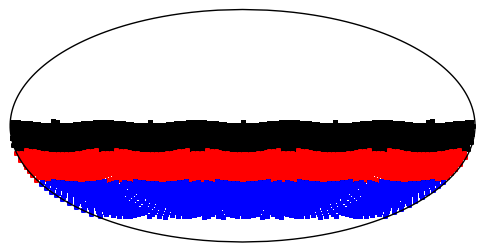

In [20]:
fig, ax = plt.subplots()
m = Basemap(#llcrnrlat=-32., llcrnrlon=48.,
            #urcrnrlat=-22., urcrnrlon=58,
            projection='moll', lon_0=0., lat_0=0., ax=ax)
xN, yN = m(dfNorthPatch.fieldRA.apply(np.degrees).values, 
           dfNorthPatch.fieldDec.apply(np.degrees).values)
xM, yM = m(dfMiddlePatch.fieldRA.apply(np.degrees).values, 
           dfMiddlePatch.fieldDec.apply(np.degrees).values)
xS, yS = m(dfSouthPatch.fieldRA.apply(np.degrees).values, 
           dfSouthPatch.fieldDec.apply(np.degrees).values)



m.scatter(xN, yN, marker='.', color='k')
m.scatter(xM, yM, marker='.', color='r')
m.scatter(xS, yS, marker='.', color='b')




In [35]:
fig.savefig('DecBands.png')

## Checks 

__Check that fieldIDs don't overlap__ in the distinct bands

In [21]:
NF = set(NorthFieldIDs.values.tolist())
MF = set(MiddleFielIDs.values.tolist())
SF = set(SouthFielIDs.values.tolist())

In [22]:
print(NF.intersection(MF))
print(NF.intersection(SF))
print(SF.intersection(MF))

set([])
set([])
set([])


__Quick approximation__ : Is the total number of fields the same in each of the patches?

In [23]:
numFieldsNorthWFD/np.float(numFieldsNorth), numFieldsMiddleWFD/np.float(numFieldsMiddle), numFieldsSouthWFD/np.float(numFieldsSouth), 

(0.9555288461538461, 0.9353658536585366, 0.8957816377171216)

In [24]:
numFieldsMiddleWFD / np.float(numFieldsNorthWFD) , numFieldsSouthWFD/np.float(numFieldsNorthWFD)

(0.9647798742138365, 0.9081761006289308)

In [25]:
numFieldsMiddle / np.float(numFieldsNorth) , numFieldsSouth/np.float(numFieldsNorth)

(0.9855769230769231, 0.96875)

So
- The number of total unique fields seems to decrease as we go South in bands despite the choice of wider bands in the South to keep the areas equal by about 3 percent (26 fields) in going from the Northern band to the Souther band
- The number of WFD deep fields in the dec bands decrease faster as we go South, falling by about 10 percent (approximately 70 fields) as we go from the Northern most band to the Southern most band, implying that the visits in the South are to different proposals
- As we check below, this is due to many of the visits being to other proposals. One that accounts for about half of the extra fields is the Galactic plane (propID 52)

In [26]:
x, nn1, nn2 = numFieldsinPatch('@b1dec', '@maxdec', patchName='North', propID=52)

fieldDec > @b1dec and fieldDec < @maxdec
Total Number of fields in North patch is 832 and 37 are in WFD


In [27]:
x, nm1, nm2 = numFieldsinPatch('@b2dec', '@b1dec', patchName='Middle', propID=52)

fieldDec > @b2dec and fieldDec < @b1dec
Total Number of fields in Middle patch is 820 and 53 are in WFD


In [28]:
x, ns1, ns2 = numFieldsinPatch('@mindec','@b2dec', patchName='South', propID=52)

fieldDec > @mindec and fieldDec < @b2dec
Total Number of fields in South patch is 806 and 84 are in WFD


We will ignore the smaller number of fields in the Southern bands for now

## Time for OpSim

We will consider visits in the last nine years of the survey to account for the fact that the first year is likely different.

In [29]:
dfall = opsout.summary.query('night > 365')

In [30]:
wfd = dfall.query('propID == 54')
numWFD = len(wfd)

In [31]:
numOther = len(dfall) - len(wfd)

In [32]:
numOther/ np.float(numWFD) 

0.11913749198460225

In [33]:
np.float(numWFD) / np.float(len(dfall))

0.8935452588820593

So, I suppose a quick approximaton will be to do only the WFD survey during the last three
years, and downsample to 89 percent of the vists. Note that galactic plane, south Celestial 
cap are done in the first year itself. So these 9 years are shared between the WFD, DDF, and 
North Ecliptic Spur.

# Scratch

In [234]:
dfall.propID.unique()

array([54, 55, 56])

In [247]:
opsout.propIDDict

{u'conf/survey/galacticplaneprop.conf': 52,
 u'conf/survey/northeclipticspur-18c.conf': 55,
 u'conf/survey/southcelestialpole-18.conf': 53,
 'ddf': 56,
 'wfd': 54}

In [248]:
opsout.summary.query('propID == 53').night.max()

321

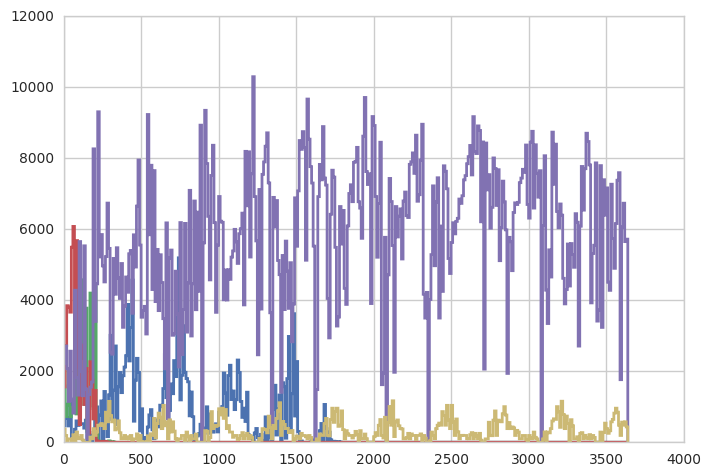

In [263]:

fig, ax = plt.subplots()
opsout.summary.query('propID == 55').night.hist(histtype='step', 
                                                bins=np.arange(0., 3650., 10.),
                                                lw=2., ax=ax)
opsout.summary.query('propID == 52').night.hist(histtype='step', 
                                                bins=np.arange(0., 3650., 10.),
                                                lw=2.,ax =ax)
opsout.summary.query('propID == 53').night.hist(histtype='step', 
                                                bins=np.arange(0., 3650., 10.),
                                                lw=2.,ax=ax)
opsout.summary.query('propID == 54').night.hist(histtype='step', 
                                                bins=np.arange(0., 3650., 10.),
                                                lw=2., ax=ax)
opsout.summary.query('propID == 56').night.hist(histtype='step', 
                                                bins=np.arange(0., 3650., 10.),
                                                lw=2., ax=ax)

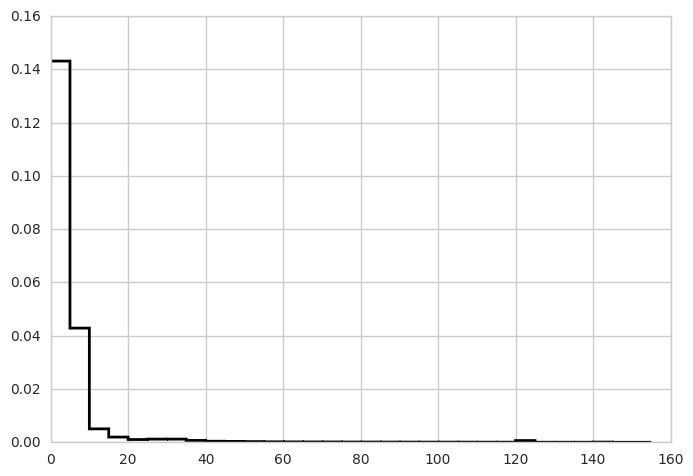

In [242]:
fig, ax = plt.subplots()
wfd.slewTime.hist(histtype='step', color='k', lw=2., alpha=1., ax=ax, bins=np.arange(0., 160., 5.), normed=1)
dfall.query('propID == 52').slewTime.hist(histtype='step', color='r', 
                                          ls='dashed', lw=2., ax=ax,
                                          bins=np.arange(0., 160., 5.), normed=1)

In [206]:
np.pi * 8.4 * 1000 /2.

13194.68914507713

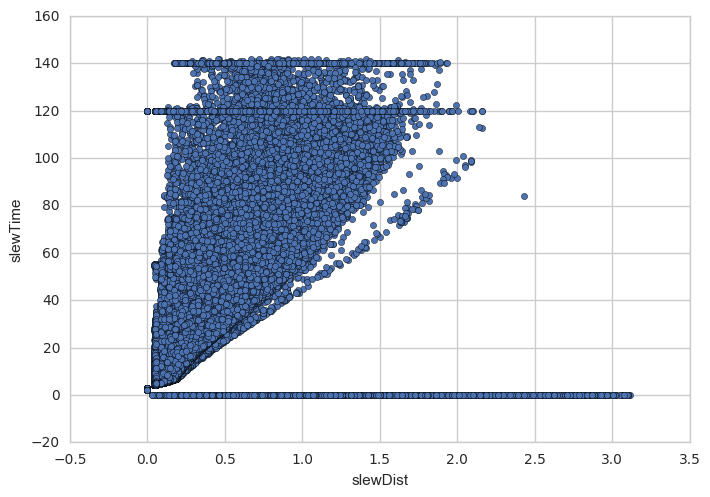

In [219]:
opsout.summary.plot(x='slewDist', y='slewTime', kind='scatter')

In [214]:
import seaborn as sns
sns.set_style('whitegrid')

In [213]:
opsout.summary.query('slewTime == 0.')

,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,visitTime,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
obsHistID,,,,,,,,,,,,,,,,,,,,,
1,1016,54,316,1.676483,-1.082473,y,2922,59580.033829,0,34.0,...,0.000000,105.610378,0.920473,0.0,0.0,1.620307,0.0,21.021236,1.643930,-1.108924
721,1016,54,320,1.256636,-1.066865,z,89332,59581.033945,1,34.0,...,0.000000,93.518017,0.866146,0.0,0.0,1.421021,0.0,21.680956,1.232915,-1.093316
1456,1016,54,329,1.143387,-1.064843,z,175740,59582.034038,2,34.0,...,0.101868,91.443555,0.725074,0.0,0.0,1.368529,0.0,21.846744,1.127631,-1.091294
2152,1016,54,343,1.031741,-1.058735,z,262146,59583.034108,3,34.0,...,1.038963,89.837659,1.182784,0.0,0.0,1.316549,0.0,21.440068,1.023949,-1.085186
2868,1016,54,619,1.502661,-0.876368,z,348551,59584.034156,4,34.0,...,3.760860,93.119785,0.670447,0.0,0.0,1.527214,0.0,21.888310,1.502661,-0.902819
3587,1016,54,1633,1.471480,-0.396223,z,434953,59585.034180,5,34.0,...,10.507108,91.524453,0.473986,0.0,0.0,1.479197,0.0,22.130133,1.475619,-0.422674
4314,1016,54,1447,1.641324,-0.469907,z,521353,59586.034181,6,34.0,...,24.389694,97.376013,1.008286,0.0,0.0,1.633668,0.0,21.508443,1.649888,-0.496358
5017,1016,54,621,1.010613,-0.876368,y,607751,59587.034159,7,34.0,...,46.055769,83.487857,0.530169,0.0,0.0,1.223847,0.0,21.701239,1.028511,-0.902819
5756,1016,54,694,1.448544,-0.834603,y,694147,59588.034114,8,34.0,...,70.457061,89.001925,0.967661,0.0,0.0,1.488819,0.0,21.182232,1.471288,-0.861054
